# Paso a paso de la segmentación y extración de texto

 ## **Hackaton RIIAA 2021 Reto 2**  
 Segmentacion y Reconocimiento de Texto en un Documento  
 **Equipo:** Pista latente ML  
 **Integrantes:**  
       - Andrea Berenice Ek Hobak  
       - Gabriela Marali Mundo Cortes  
       - Mario Xavier Canche Uc  
       - Myrna Citlali Castillo Silva  
       - Ramon Sidonio Aparicio Garcia  

## Montamos carpeta en Drive

In [1]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [3]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/Hackaton2021/codigo/Entregables/Reto2")
!ls

Genera_Entregable_Reto2A.ipynb	output	     StepByStep_Reto2A.ipynb
model				__pycache__  TextRecognition.py


## Instalamos las librerias

In [4]:
# Instalamos Tesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [5]:
# Instalamos tesseract para python
!pip install pytesseract

In [6]:
# Instalamos pylsd, it  is the python bindings for LSD - Line Segment Detector
!pip install ocrd-fork-pylsd

## Descargamos y copiamos el BEST MODEL LSTM

In [7]:
# Descargar el mejor modelo del github de tesseract
# https://github.com/tesseract-ocr/tessdata_best

# Eliminamos el modelo default
%rm /usr/share/tesseract-ocr/4.00/tessdata/eng.traineddata 

# Copiamos el modelo descargado
%cp model/eng.traineddata /usr/share/tesseract-ocr/4.00/tessdata/ 

## Cargamos las librerias

In [8]:
# Cargamos las librerias
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pytesseract

from scipy import ndimage
import re


## Cargamos la imagen del documento

In [9]:
# Ruta de imagenes del hackaton
archivo_scr = "../../../Datos - Hackathon JusticIA/Evaluacion/Reto2/Ficheros_ACNR_militantes_Olea_Castaneyra_Rafel_Olea_Castaneyra_Rafael,_ACNR-19-.JPG"

# Cargamos la imagen
image = PIL.Image.open(archivo_scr).convert("RGB")
image = np.array(image)

(3456, 4608, 3)


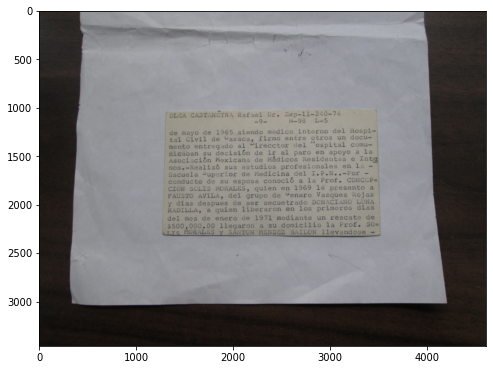

In [10]:
print(image.shape)
# Visualizamos la imagen
plt.figure(figsize=(8,10))
plt.imshow(image)
plt.show()

## Registramos (recortamos/orientamos) el documento

[INFO] otsu's thresholding value: 89.0


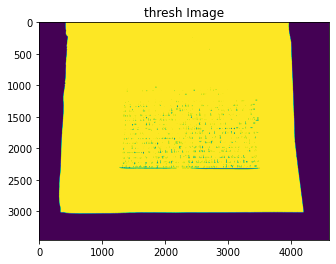

In [11]:
# convert the warped image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
# sharpen image
sharpen = cv2.GaussianBlur(gray, (7,7), 0)

#Get the best value for T with otsu thresholding
(T, threshInv) = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
threshInv = cv2.erode(threshInv, None, iterations=2)
threshInv = cv2.dilate(threshInv, None, iterations=2)

print("[INFO] otsu's thresholding value: {}".format(T))
#plt.figure(figsize=(10,12))
plt.imshow(threshInv)
plt.title("thresh Image")
plt.show()

In [12]:
# Detectamos los perfiles del documento segmentado
profile_h = threshInv.sum(0)
profile_v = threshInv.sum(1)

eje_x = np.where(profile_h > 200000)[0]
eje_y = np.where(profile_v > 200000)[0]

coor_x0 = eje_x[0]
coor_xf = eje_x[len(eje_x)-1]
coor_y0 = eje_y[0]
coor_yf = eje_y[len(eje_y)-1]

image = image[coor_y0:coor_yf,coor_x0:coor_xf,:]

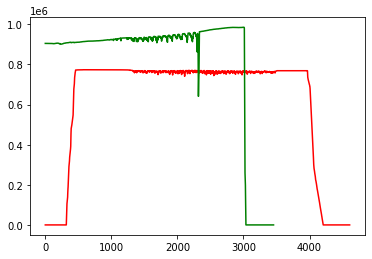

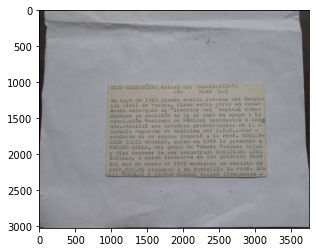

In [13]:
plt.plot(profile_h,"r")
plt.plot(profile_v,"g")
plt.show()

plt.imshow(image)
plt.show()

## Detectamos la orientacion del documento

In [14]:
if image.shape[1]<4000: 
    # Detectamos la orientacion con tesseract
    osd = pytesseract.image_to_osd(image)
    print(osd)

    # visualizamos el angulo
    angle = 360-int(re.search('(?<=Rotate: )\d+', osd).group(0))
    print(angle)
else:
    angle = 0

Page number: 0
Orientation in degrees: 0
Rotate: 0
Orientation confidence: 2.35
Script: Latin
Script confidence: 14.74

360


In [15]:
# Rotamos la imagen en caso de ser necesario
if angle!=0 and angle!=360: 
    rotated = ndimage.rotate(image, float(angle))

    # Visualizamos la imagen
    plt.figure(figsize=(8,10))
    plt.imshow(rotated)
    plt.show()

    image = rotated

    #cv2.imwrite("rotated_image.png",rotated)

## Limpieza de la Imagen

In [16]:
# convert the warped image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# sharpen image
sharpen = cv2.GaussianBlur(gray, (0,0), 3)
sharpen = cv2.addWeighted(gray, 1.5, sharpen, -0.5, 0)

# apply adaptive threshold to get black and white effect
thresh = cv2.adaptiveThreshold(sharpen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 71, 21)


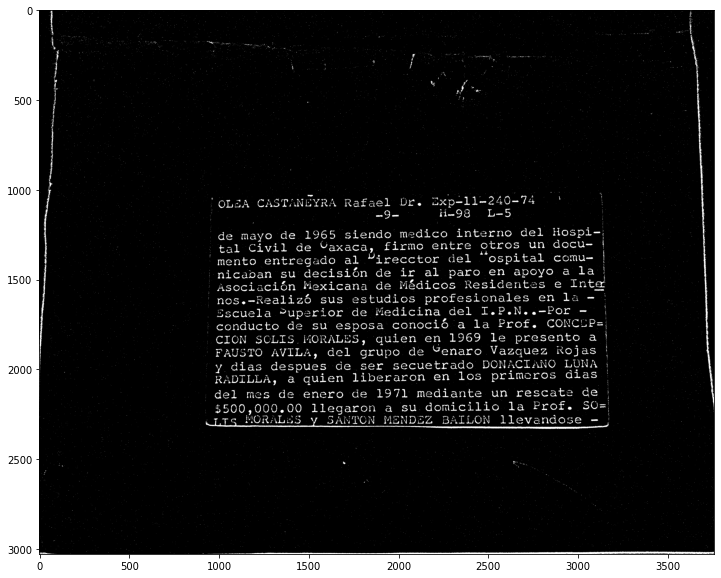

In [17]:
# Visualizamos la imagen
plt.figure(figsize=(15,10))
plt.imshow(thresh,cmap="gray")
plt.show()

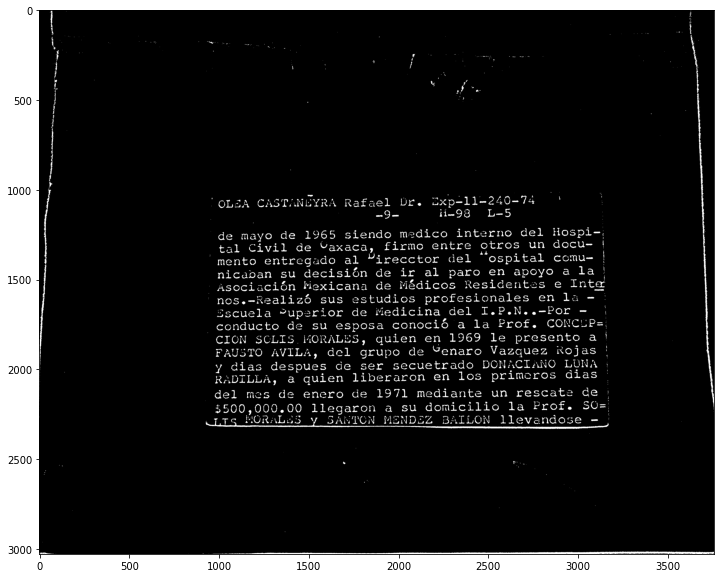

In [18]:
# Limpieza de la imagen segmentada
thresh = cv2.medianBlur(thresh,3)

# Visualizamos la imagen
plt.figure(figsize=(15,10))
plt.imshow(thresh,cmap="gray")
plt.show()

## Analysis of connected components

In [19]:
from scipy import ndimage

label_im, nb_labels = ndimage.label(thresh)
nb_labels # how many regions?

1699

In [20]:
sizes = ndimage.sum(thresh, label_im, range(nb_labels + 1))

In [21]:
mask_size = sizes < 2000
remove_pixel = mask_size[label_im]
remove_pixel.shape
label_im[remove_pixel] = 0

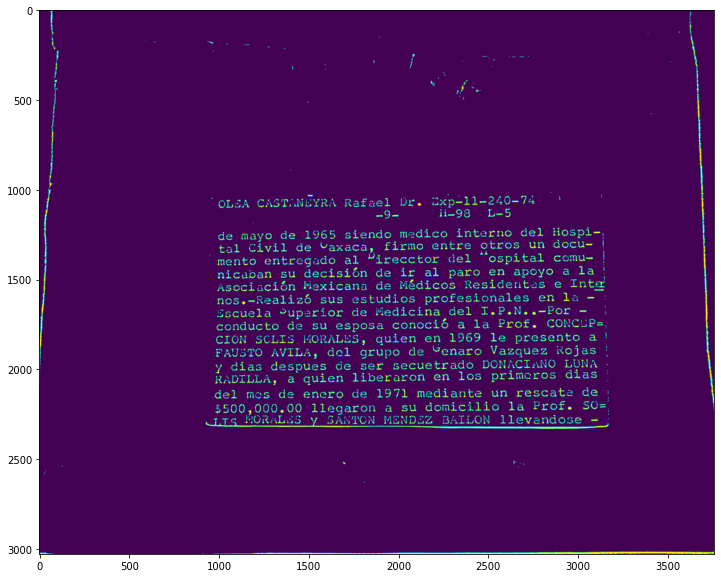

In [22]:
# Visualizamos la imagen
plt.figure(figsize=(15,10))
plt.imshow(label_im>0)
plt.show()

## Reconocemos el texto con Tesseract Python

In [23]:
output1 = pytesseract.image_to_string(label_im>0, lang="eng")
#output = pytesseract.image_to_string(erode, lang="eng")
print(output1)

gan

SK
anand RENCE pv I.

'OLSA CAST.NLYRA Rafael Ur. Oxp-11-240-74
| ~9- 1i-93 L-5
de mayo de 1965 siendo madico interno del Hospl-,
tal Civil de VYaxaca, firmo entre otros un docu- |
"mento entregado al Yirecctor del *ospital ccmu- |!
nicaban su decisidn de ir al paro en apoyo a la!

Asociaciébn Mexicana de Médicos Residentes e Int
nos.—-Realizd sus estudios profesionales en la -
Sscuela ~uparior de Medicina del I.P.N..-Por -
conducto de su esposa conocid a la Prof. CONHCUP=,

i

CION SCLIS MORALES, quien en 1969 le presento a
FAUSTO AVILA, del grupo de “Yenaro Vazquez Rojas |
vy dias despues de ser secuetrado DONACIANO LUNA
RADILLA, a quien liberaron en los primcros dias
del mes de enero de 1971 mediante un rescates de
$500,000.00 llegaron a su domicilio la Prof. SO=.
MORALLS vv SANTCON MENDIZ BAILON llevandose - |

 

 

